# Arizona Coyotes - Venue Relocation
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Jan 14, 2022

## Hypothesis
With the Coyotes undergoing a venue relocation, we think that the distToVenue feature could have a significant impact on Full Season buyers. This notebook will simulate a venue relocation and compare against current retention scores.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *
from ngboost import NGBClassifier

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ··················


In [3]:
lkupclientid = 55 # coyotes
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrCoyotes].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(17399, 55)

### Let's specify the default SA features for our model:

In [23]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
    "attendancePercent",
    "distToVenue",
    "isNextYear_Buyer",
    "productGrouping",
    "recency",
    "source_tenure",
    "totalSpent",
    "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (11598, 9)
Unseen Data For Predictions: (2047, 9)



### Let's isolate just Full Season buyers and measure their distToVenue:

In [27]:
df_full_season = df_train.loc[df_train["productGrouping"] == "Full Season"]
df_full_season.shape

(4589, 9)

### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [10]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
        "distToVenue",
        "recency",
        "source_tenure",
        "totalSpent"
    ]
);

### Let's compare all models to evaluate performance. The output prints a score grid that shows average Accuracy, AUC, Recall, Precision, F1 and Kappa accross the folds (10 by default) along with training time:

In [11]:
# adding an extra classifier ngboost
ngc = NGBClassifier()
ngboost = create_model(ngc)

model_matrix = compare_models(
    fold=10,
    include=["gbc", "lightgbm", "lr", ngboost, "rf", "xgboost"],
    sort="AUC"
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
1,Light Gradient Boosting Machine,0.7159,0.7661,0.5663,0.6620,0.6102,0.3888,0.3919,0.0300
0,Gradient Boosting Classifier,0.7141,0.7635,0.5782,0.6545,0.6138,0.3883,0.3903,0.2740
5,Extreme Gradient Boosting,0.7134,0.7610,0.5630,0.6586,0.6068,0.3836,0.3867,0.3630
3,NGBClassifier,0.7024,0.7541,0.5777,0.6329,0.6039,0.3664,0.3674,1.6190
4,Random Forest Classifier,0.6946,0.7403,0.5653,0.6233,0.5926,0.3493,0.3505,0.2340
2,Logistic Regression,0.6435,0.6385,0.3034,0.5891,0.3839,0.1803,0.1998,0.0150


### Now that we have the best performing model, we can finalize it:

In [12]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7312,0.7804,0.5995,0.6784,0.6365,0.4246,0.4266
1,0.7079,0.7680,0.5323,0.6581,0.5886,0.3661,0.3710
2,0.7099,0.7388,0.5478,0.6563,0.5972,0.3734,0.3771
3,0.7170,0.7694,0.5401,0.6742,0.5997,0.3850,0.3907
4,0.7373,0.7889,0.5954,0.6937,0.6408,0.4356,0.4388
5,0.7018,0.7576,0.5464,0.6424,0.5905,0.3585,0.3614
6,0.7181,0.7754,0.5954,0.6562,0.6243,0.3995,0.4007
7,0.7110,0.7688,0.5515,0.6585,0.6003,0.3767,0.3803
8,0.7239,0.7808,0.5840,0.6706,0.6243,0.4077,0.4101
9,0.7005,0.7334,0.5711,0.6314,0.5997,0.3614,0.3626


### Let's load in our 2021 season data and get retention scores using the model:

In [ ]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(2418, 55)

In [ ]:
#new_predictions = new_predictions.loc[new_predictions["productGrouping"] == "Full Season"]

In [ ]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,urbanicity,isnextyear_buyer,isnextyear_samepkg_buyer,pkgupgrade_status,auto_renewal,credits_after_refund,isNextYear_Buyer,Label,Score_0,Score_1
14981,55,2588,113499,2021,Full Season,5688.9,2022-01-08,0.625000,54,TRUE,...,0,0,0,0,0,1389.0,0,1,0.1631,0.8369
14982,55,3424,15630773,2021,Partial Season,1314.0,2022-01-08,0.722222,80,TRUE,...,0,0,0,0,0,0.0,0,0,0.9608,0.0392
14983,55,9878,15425074,2021,Partial Season,1469.0,2022-01-06,0.833333,82,TRUE,...,0,0,0,0,0,0.0,0,0,0.8531,0.1469
14984,55,10694,16478295,2021,Partial Season,1452.0,2021-12-10,0.800000,62,TRUE,...,0,0,0,0,0,0.0,0,0,0.9382,0.0618
14985,55,14576,16981634,2021,Full Season,6755.3,2022-01-08,0.937500,48,TRUE,...,0,0,0,0,0,0.0,0,0,0.6422,0.3578


In [15]:
new_predictions['Label'].value_counts()

0    1687
1     731
Name: Label, dtype: int64

### We can plot the scores using a histogram to see the score distribution for buyers:

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

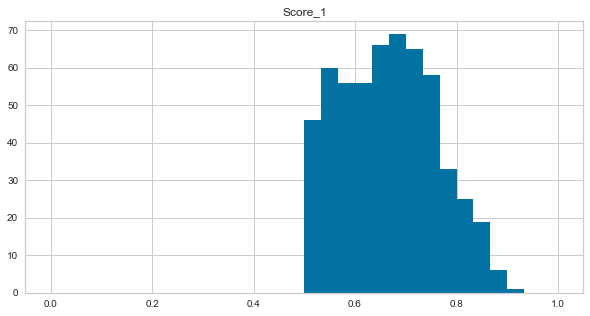

In [29]:

new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

### Let's plot the feature importances to see what features in the model are most predictive:

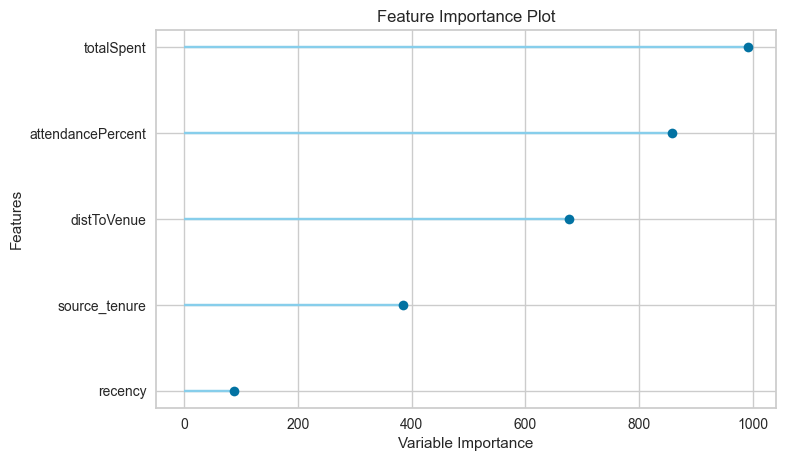

In [28]:
plot_model(best_model, plot='feature')

### Using a confusion matrix can also help us understand where the model is predicting correctly and where it's missing:

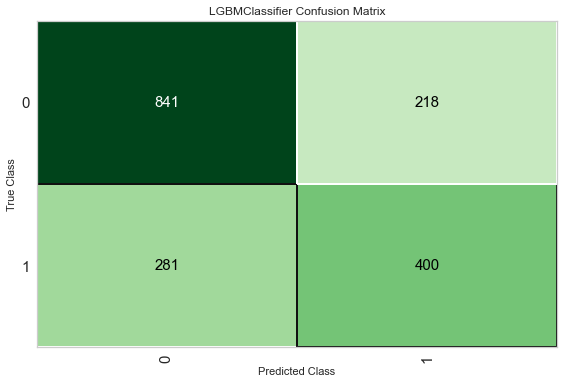

In [18]:
plot_model(best_model, plot='confusion_matrix')

### Let's also visualize the AUC (area under the curve) to get a sense of how our model is performing:

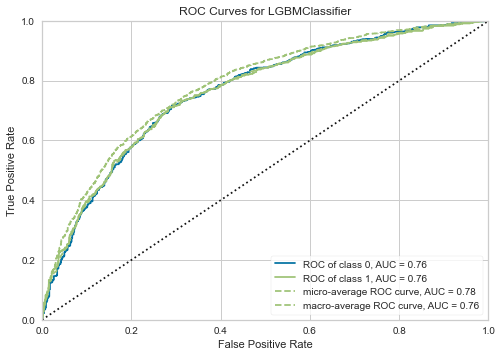

In [19]:
plot_model(best_model, plot="auc")

## Observations

* The model predictions are ~ 75% accurate 

* The Full Season ticket buyers fall into a Normal Distribution, as is expected.

* distToVenue is the third most important feature, with a variable importance ~ 75%

* The model made 3x as many correct predictions vs. incorrect predictions

## Conclusions

The distToVenue feature did prove to be a useful feature for model predictions. The next experiment will focus on altering the distToVenue feature to understand the impact (or non-impact) on model performance (i.e. does adding distance to the feature improve accuracy or have little to no impact).